# Experiment 1: Network Topology Variability - Fixed Buffer Analysis

**Approach**: Average over shocks first, then analyze variability across networks

## Methodology
1. For each network: Compute mean risk reduction across 100 shock scenarios
2. Across networks: Show mean and 25-75 percentile of these network-level means
3. Normalize risk reduction by R_unc to measure **fraction of risk eliminated**

## Interpretation
- **Mean line**: Average performance across network topologies
- **Shaded band**: How much does network structure affect results?
- **Normalized metric**: (R_unc - R_comp) / R_unc = fraction of risk eliminated by compression
- Separates network topology uncertainty from shock randomness

## Key Research Question
Does network compression (via CDFD) reduce systemic risk when institutions maintain fixed pre-compression capital buffers?

## 1. Setup and Imports

In [1]:

#!/usr/bin/env python3
import numpy as np
import pandas as pd
from scipy.sparse import csr_array
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from risk_analysis import (
    generate_compression_network,
    assign_weights_to_network,
    generate_correlated_shocks
)
from full_payment_algo import full_payment_algo
from CDFD import CDFD_BFF, CDFD_min_cost_pulp
from copula_shock_generator_fixed import generate_gaussian_copula_shocks
# Styling
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.1)
plt.rcParams['figure.dpi'] = 100
np.set_printoptions(suppress=True, precision=4)

print("✓ Imports complete")

✓ Imports complete


## 2. Experimental Parameters

In [2]:
# Network structure
N_core = 50
num_sources = 2
num_sinks = 3
p = 0.5
N_total = N_core + num_sources + num_sinks

# Monte Carlo parameters
NUM_NETWORKS = 500             # Number of network realizations
NUM_SHOCK_SCENARIOS = 100     # Number of shock realizations per network
base_network_seed = 1000
shock_base_seed = 2025
rho = 0.5                      # Shock correlation

# Gamma sweep
NUM_GAMMA_POINTS = 30
GAMMA_MAX_MULTIPLIER = 3

print("Experimental Configuration")
print("=" * 70)
print(f"Network: {N_total} nodes ({num_sources} sources + {N_core} core + {num_sinks} sinks)")
print(f"Core edge probability: p = {p}")
print(f"Shock correlation: ρ = {rho}")
print(f"\nNetworks: {NUM_NETWORKS}")
print(f"Shocks per network: {NUM_SHOCK_SCENARIOS}")
print(f"Gamma points: {NUM_GAMMA_POINTS}")
print(f"Total simulations: {NUM_NETWORKS * NUM_SHOCK_SCENARIOS * NUM_GAMMA_POINTS * 3:,}")
print("=" * 70)

Experimental Configuration
Network: 55 nodes (2 sources + 50 core + 3 sinks)
Core edge probability: p = 0.5
Shock correlation: ρ = 0.5

Networks: 500
Shocks per network: 100
Gamma points: 30
Total simulations: 4,500,000


## 3. Helper Functions

In [3]:
def compute_system_shortfall(W_net, buffer_vec, gamma, epsilon, DeltaP=1.0):
    """
    Compute system-level shortfall R(W, b, ξ).
    
    Parameters
    ----------
    W_net : ndarray
        Network flow matrix (N × N)
    buffer_vec : ndarray
        Node-level capital buffers
    gamma : float
        Shock magnitude
    epsilon : ndarray
        Shock realization vector
    DeltaP : float
        Price shock multiplier
    
    Returns
    -------
    float
        System-level shortfall
    """
    e0 = buffer_vec - gamma * epsilon
    L = DeltaP * W_net
    p_bar, *_ = full_payment_algo(L, e0)
    return float(np.asarray(p_bar).ravel().sum())


print("✓ Helper functions defined")
print("  - compute_system_shortfall()")

✓ Helper functions defined
  - compute_system_shortfall()


## 4. Generate and Compress Networks

In [4]:
print("Generating multiple networks...")
networks_list = {}
buffers_list = []

for net_idx in range(NUM_NETWORKS):
    if (net_idx + 1) % 10 == 0:
        print(f"  Network {net_idx + 1}/{NUM_NETWORKS}...")
    
    network_seed = base_network_seed + net_idx
    
    # Generate network
    W_struct, _, _, _ = generate_compression_network(
        N_core, p, num_sources, num_sinks, seed=network_seed
    )
    W_orig = assign_weights_to_network(W_struct, alpha=2.0, scale=1.0)
    buffer_orig = W_orig.sum(axis=1) * 1.1
    
    # Store original
    if net_idx == 0:
        networks_list['Original'] = []
    networks_list['Original'].append(W_orig)
    buffers_list.append(buffer_orig)
    
    # Compress with BFF
    try:
        W_sparse = csr_array(W_orig)
        _, D = CDFD_BFF(W_sparse, TOL_ZERO=1e-5)
        if net_idx == 0:
            networks_list['BFF'] = []
        networks_list['BFF'].append(D.toarray())
    except Exception as e:
        print(f"  Network {net_idx} BFF failed: {e}")
    
    # Compress with Maximal
    try:
        _, D = CDFD_min_cost_pulp(W_sparse, TOL_ZERO=1e-5)
        if net_idx == 0:
            networks_list['Maximal'] = []
        networks_list['Maximal'].append(D.toarray())
    except Exception as e:
        print(f"  Network {net_idx} Maximal failed: {e}")

active_methods = list(networks_list.keys())
print(f"\n✓ Generated {NUM_NETWORKS} networks")
print(f"  Active methods: {active_methods}")
print(f"  Networks per method: {len(networks_list['Original'])}")

# Compute median buffer from first network
median_buffer = np.median(buffers_list[0])
print(f"\nMedian buffer (network 0): {median_buffer:.2f}")

Generating multiple networks...
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/yijie/.pyenv/versions/3.11.12/envs/myenv311/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/8m/tlrl9p6s7371ym2ydbzyxkbw0000gn/T/920161464db64e9ea659e536d0764f8c-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/8m/tlrl9p6s7371ym2ydbzyxkbw0000gn/T/920161464db64e9ea659e536d0764f8c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 60 COLUMNS
At line 4099 RHS
At line 4155 BOUNDS
At line 5502 ENDATA
Problem MODEL has 55 rows, 1346 columns and 2692 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 54 (-1) rows, 1321 (-25) columns and 2642 (-50) elements
Perturbing problem by 0.001% of 1 - largest nonzero change 5.5448568e-05 ( 0.0055448568%) - largest zero change 0
0  Obj 208.65804 Primal inf 631.79905 (54)
44  Obj 517.26537 Prima

## 5. Multi-Network, Multi-Shock Analysis

In [5]:
# Determine gamma range
gamma_max = GAMMA_MAX_MULTIPLIER * median_buffer
gamma_values = np.linspace(0.0, gamma_max, NUM_GAMMA_POINTS)

print("Running multi-network, multi-shock analysis...")
print("=" * 70)
print(f"Gamma range: [0, {gamma_max:.2f}] ({NUM_GAMMA_POINTS} points)")
print(f"Networks: {NUM_NETWORKS}")
print(f"Shock scenarios per network: {NUM_SHOCK_SCENARIOS}")
print(f"Total simulations: {NUM_NETWORKS * NUM_SHOCK_SCENARIOS * NUM_GAMMA_POINTS * len(active_methods):,}")
print()

# Storage: {method: (NUM_NETWORKS, NUM_GAMMA, NUM_SHOCKS)}
all_risk_reductions = {
    method: np.zeros((NUM_NETWORKS, NUM_GAMMA_POINTS, NUM_SHOCK_SCENARIOS))
    for method in active_methods if method != 'Original'
}

all_R_unc = np.zeros((NUM_NETWORKS, NUM_GAMMA_POINTS, NUM_SHOCK_SCENARIOS))

# Pre-compute total obligations for each network (used for normalization)
total_obligations = np.zeros(NUM_NETWORKS)
for net_idx in range(NUM_NETWORKS):
    W_orig = networks_list['Original'][net_idx]
    total_obligations[net_idx] = W_orig.sum()

print(f"  Total obligations range: [{total_obligations.min():.2f}, {total_obligations.max():.2f}]")

# Run analysis
for net_idx in range(NUM_NETWORKS):
    if (net_idx + 1) % 5 == 0:
        print(f"  Processing network {net_idx + 1}/{NUM_NETWORKS}...")

    W_orig = networks_list['Original'][net_idx]
    buffer_orig = buffers_list[net_idx]
    obligations = total_obligations[net_idx]

    for shock_idx in range(NUM_SHOCK_SCENARIOS):
        # Generate shock (unique per network-shock combination)
        shock_seed = shock_base_seed + net_idx * 10000 + shock_idx
        epsilon = generate_gaussian_copula_shocks(N_total, rho, n_samples=1, seed=shock_seed).ravel()

        # For each gamma value
        for gamma_idx, gamma in enumerate(gamma_values):
            # Compute original network shortfall
            R_unc_raw = compute_system_shortfall(W_orig, buffer_orig, gamma, epsilon)
            # Normalize by total obligations and store
            R_unc_norm = R_unc_raw / obligations
            all_R_unc[net_idx, gamma_idx, shock_idx] = R_unc_norm

            # For each compression method
            for method_name in active_methods:
                if method_name == 'Original':
                    continue

                W_comp = networks_list[method_name][net_idx]
                R_comp_raw = compute_system_shortfall(W_comp, buffer_orig, gamma, epsilon)
                # Compute normalized risk reduction directly
                # (R_unc - R_comp) / R_unc
                if R_unc_raw!=0:
                    risk_reduction_norm = (R_unc_raw - R_comp_raw) / R_unc_raw
                else:
                    risk_reduction_norm =0
                
                all_risk_reductions[method_name][net_idx, gamma_idx, shock_idx] = risk_reduction_norm

print()
print("=" * 70)
print("✓ Analysis complete")
print(f"  Normalization: (R_unc - R_comp) / total_obligations")
print(f"  This represents fraction of total obligations saved")

Running multi-network, multi-shock analysis...
Gamma range: [0, 150.47] (30 points)
Networks: 500
Shock scenarios per network: 100
Total simulations: 4,500,000

  Total obligations range: [2401.18, 2841.08]
  Processing network 5/500...
  Processing network 10/500...
  Processing network 15/500...
  Processing network 20/500...
  Processing network 25/500...
  Processing network 30/500...
  Processing network 35/500...
  Processing network 40/500...
  Processing network 45/500...
  Processing network 50/500...
  Processing network 55/500...
  Processing network 60/500...
  Processing network 65/500...
  Processing network 70/500...
  Processing network 75/500...
  Processing network 80/500...
  Processing network 85/500...
  Processing network 90/500...
  Processing network 95/500...
  Processing network 100/500...
  Processing network 105/500...
  Processing network 110/500...
  Processing network 115/500...
  Processing network 120/500...
  Processing network 125/500...
  Processing 

In [6]:
# all_risk_reductions

## 6. Aggregate Results (Option 1: Network Variability)

**Step 1**: Average over shocks for each network  
**Step 2**: Compute statistics across networks

In [7]:
print("Computing aggregated metrics (Option 1: Network variability)...")
print("=" * 70)
print("Step 1: Average over shocks for each network")
print("Step 2: Compute statistics across networks")
print()

results = {
    'gamma_values': gamma_values,
    'methods': {}
}

# For each compression method
for method_name in active_methods:
    if method_name == 'Original':
        continue

    # Get risk reductions: (NUM_NETWORKS, NUM_GAMMA, NUM_SHOCKS)
    risk_reductions = all_risk_reductions[method_name]
    R_unc_full = all_R_unc

    # STEP 1: Average over shocks (axis=2)
    # Result: (NUM_NETWORKS, NUM_GAMMA)
    # reduction_per_network is already normalized: (R_unc - R_comp) / obligations
    reduction_per_network = risk_reductions.mean(axis=2)

    # Also compute R_unc mean for reference
    R_unc_per_network = R_unc_full.mean(axis=2)

    # STEP 2: Compute statistics across networks (axis=0)
    reduction_mean = reduction_per_network.mean(axis=0)
    reduction_std = reduction_per_network.std(axis=0)
    reduction_p25 = np.percentile(reduction_per_network, 25, axis=0)
    reduction_p75 = np.percentile(reduction_per_network, 75, axis=0)

    # Compute flow retention
    network_sums = np.array([net.sum() for net in networks_list[method_name]])
    original_sums = np.array([net.sum() for net in networks_list['Original']])
    flow_retained = (network_sums / original_sums).mean()

    results['methods'][method_name] = {
        'reduction_mean': reduction_mean,  # Fraction of obligations saved (PRIMARY METRIC)
        'reduction_std': reduction_std,
        'reduction_p25': reduction_p25,
        'reduction_p75': reduction_p75,
        'reduction_all_networks': reduction_per_network,
        'flow_retained': flow_retained,
        'R_unc_mean': R_unc_per_network.mean(axis=0),
        'R_unc_std': R_unc_per_network.std(axis=0)
    }
print("=" * 70)
print("✓ Aggregation complete")

Computing aggregated metrics (Option 1: Network variability)...
Step 1: Average over shocks for each network
Step 2: Compute statistics across networks

✓ Aggregation complete


## 7a. Visualization 2: Risk Reduction vs Gamma

Plot risk reduction: $(R_{unc} - R_{comp}) / T_{total}$ with network topology variability bands.

This metric represents the **fraction of total obligations saved** by compression.

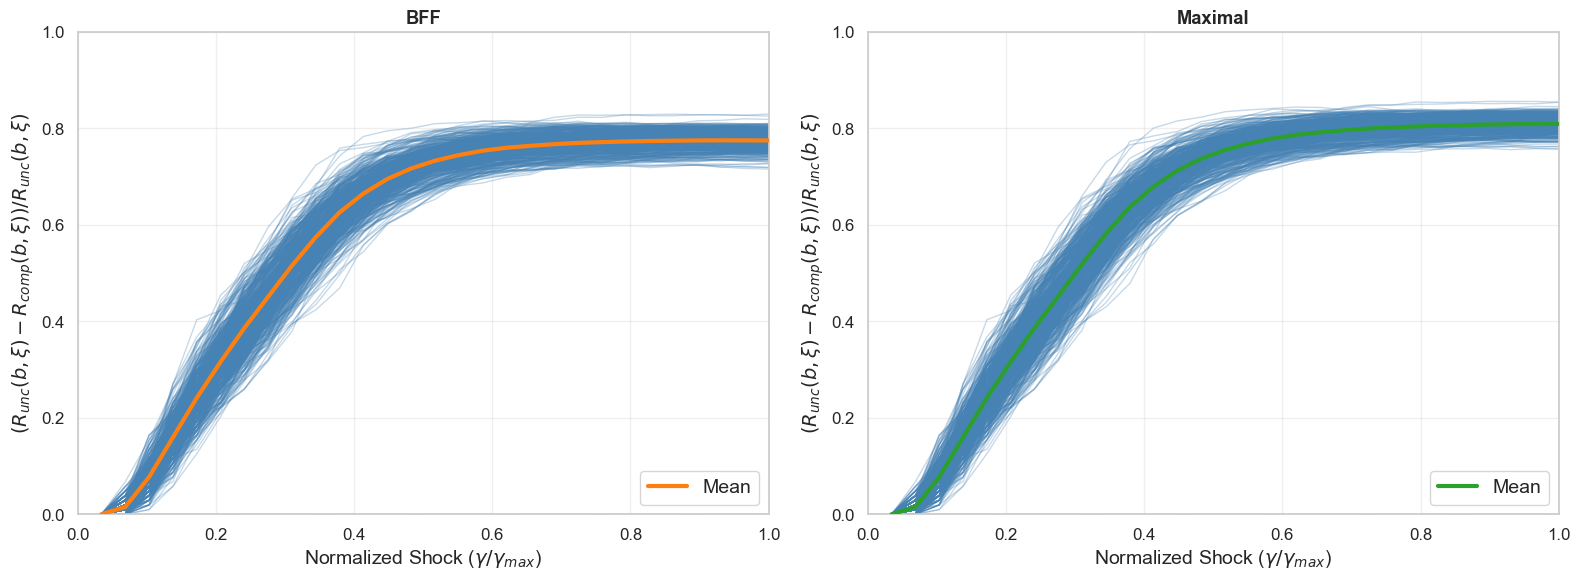

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

gamma_normalized = gamma_values / gamma_values.max()
mask = gamma_normalized > 0

# Plot 1: BFF
if 'BFF' in results['methods']:
    reduction_networks = results['methods']['BFF']['reduction_all_networks']
    reduction_mean = results['methods']['BFF']['reduction_mean']
    reduction_p25 = results['methods']['BFF']['reduction_p25']
    reduction_p75 = results['methods']['BFF']['reduction_p75']

    for net_idx in range(NUM_NETWORKS):
        ax1.plot(gamma_normalized[mask], reduction_networks[net_idx, mask],
                alpha=0.3, color='steelblue', linewidth=1)

    ax1.plot(gamma_normalized[mask], reduction_mean[mask],
            linewidth=3, color = '#ff7f0e', label='Mean', zorder=10)
    # ax1.fill_between(gamma_normalized[mask], reduction_p25[mask], reduction_p75[mask],
    #                  alpha=0.3, color='orange', label='25-75 percentile', zorder=5)
    ax1.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)

    ax1.set_xlabel(r'Normalized Shock ($\gamma / \gamma_{max}$)', fontsize=14)
    ax1.set_ylabel(r'$(R_{unc}(b,\xi) - R_{comp}(b,\xi)) / R_{unc}(b,\xi) $', fontsize=14)
    ax1.set_title(f'BFF', fontweight='bold')
    ax1.legend(fontsize=14,loc='lower right')
    ax1.grid(alpha=0.3)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)

# Plot 2: Maximal
if 'Maximal' in results['methods']:
    reduction_networks = results['methods']['Maximal']['reduction_all_networks']
    reduction_mean = results['methods']['Maximal']['reduction_mean']
    reduction_p25 = results['methods']['Maximal']['reduction_p25']
    reduction_p75 = results['methods']['Maximal']['reduction_p75']

    for net_idx in range(NUM_NETWORKS):
        ax2.plot(gamma_normalized[mask], reduction_networks[net_idx, mask],
                alpha=0.3, color='steelblue', linewidth=1)

    ax2.plot(gamma_normalized[mask], reduction_mean[mask],
            linewidth=3, color='#2ca02c', label='Mean', zorder=10)
    # ax2.fill_between(gamma_normalized[mask], reduction_p25[mask], reduction_p75[mask],
    #                  alpha=0.3, color='orange', label='25-75 percentile', zorder=5)
    ax2.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)

    ax2.set_xlabel(r'Normalized Shock ($\gamma / \gamma_{max}$)', fontsize=14)
    ax2.set_ylabel(r'$(R_{unc}(b,\xi) - R_{comp}(b,\xi)) / R_{unc}(b,\xi) $', fontsize=14)
    ax2.set_title(f'Maximal', fontweight='bold')
    ax2.legend(fontsize=14,loc='lower right')
    ax2.grid(alpha=0.3)
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('figures/Experiment1_SB_individual_trajectory_average_over_shock.png', dpi=300, bbox_inches='tight')

plt.show()

## 7b. Individual Network Trajectories: Normalized Risk Reduction

Show individual network responses for normalized metric.

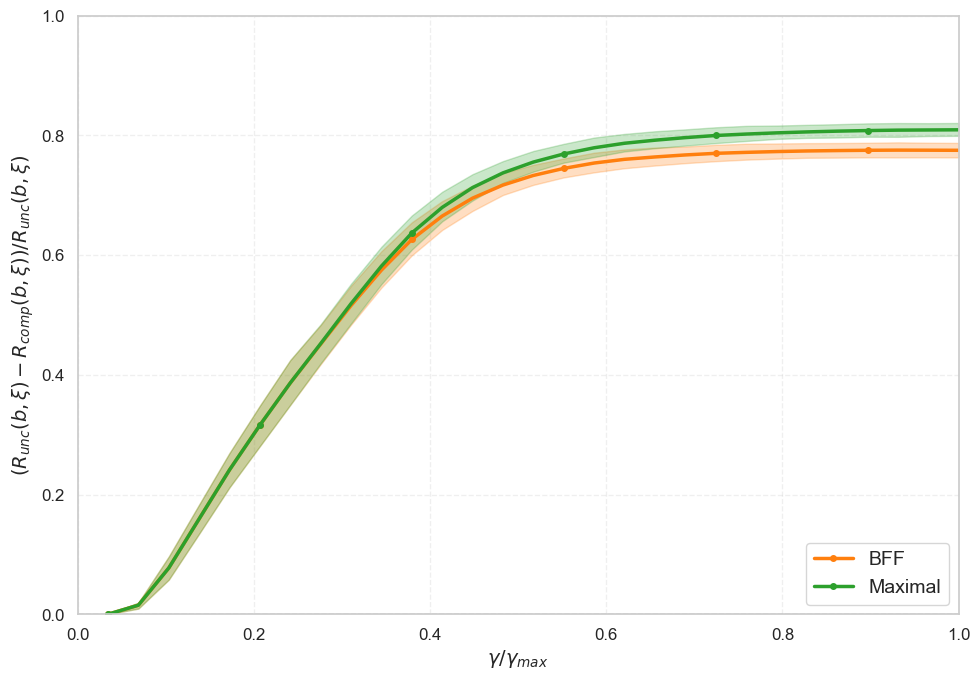

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# Normalize gamma
gamma_normalized = gamma_values / gamma_values.max()
mask = gamma_normalized > 0  # Exclude gamma=0

for method_name in ['BFF', 'Maximal']:
    if method_name not in results['methods']:
        continue

    reduction_mean = results['methods'][method_name]['reduction_mean'][mask]
    reduction_p25 = results['methods'][method_name]['reduction_p25'][mask]
    reduction_p75 = results['methods'][method_name]['reduction_p75'][mask]
    flow_retained = results['methods'][method_name]['flow_retained']

    # Plot mean line
    label = f'{method_name}'
    color = '#ff7f0e' if method_name == 'BFF' else '#2ca02c'
    line = ax.plot(gamma_normalized[mask], reduction_mean, linewidth=2.5,
                   label=label, marker='o', markersize=4, markevery=5, color=color)[0]

    # Fill 25-75 percentile band
    ax.fill_between(gamma_normalized[mask], reduction_p25, reduction_p75,
                    alpha=0.25, color=color)

# Reference line
ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel(r'$\gamma / \gamma_{max}$', fontsize=14, fontweight='bold')
ax.set_ylabel(r'$(R_{unc}(b,\xi) - R_{comp}(b,\xi)) / R_{unc}(b,\xi)$', fontsize=14, fontweight='bold')
# ax.set_title(f'Risk Reduction vs Shock Magnitude\n' +
#              f'Mean across {NUM_NETWORKS} networks (each averaged over {NUM_SHOCK_SCENARIOS} shocks)\n' +
#              f'Shaded: Network topology variability (25-75 percentile)',
#              fontsize=13, fontweight='bold')
ax.legend(fontsize=14, loc='lower right')
ax.grid(alpha=0.3, linestyle='--')
ax.set_xlim(0, 1)
ax.set_ylim(bottom=0, top=1)
plt.savefig('figures/Experiment1_figure1_risk_comparison_average_over_shock.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

## 6. Aggregate Results (Option 2: Shock Scenario Variability)

**Step 1**: Average over networks for each shock scenario  
**Step 2**: Compute statistics across shock scenarios

In [10]:
print("Computing aggregated metrics (Option 2: Shock scenario variability)...")
print("=" * 70)
print("Step 1: Average over networks for each shock scenario")
print("Step 2: Compute statistics across shock scenarios")
print()

results_v2 = {
    'gamma_values': gamma_values,
    'methods': {}
}

# For each compression method
for method_name in active_methods:
    if method_name == 'Original':
        continue

    # Get risk reductions: (NUM_NETWORKS, NUM_GAMMA, NUM_SHOCKS)
    risk_reductions = all_risk_reductions[method_name]
    R_unc_full = all_R_unc

    # STEP 1: Average over networks (axis=0)
    # Result: (NUM_GAMMA, NUM_SHOCKS)
    # reduction_per_shock is already normalized: (R_unc - R_comp) / R_unc
    reduction_per_shock = risk_reductions.mean(axis=0)

    # Also compute R_unc mean for reference
    R_unc_per_shock = R_unc_full.mean(axis=0)

    # STEP 2: Compute statistics across shock scenarios (axis=1)
    reduction_mean = reduction_per_shock.mean(axis=1)
    reduction_std = reduction_per_shock.std(axis=1)
    reduction_p25 = np.percentile(reduction_per_shock, 25, axis=1)
    reduction_p75 = np.percentile(reduction_per_shock, 75, axis=1)

    # Compute flow retention
    network_sums = np.array([net.sum() for net in networks_list[method_name]])
    original_sums = np.array([net.sum() for net in networks_list['Original']])
    flow_retained = (network_sums / original_sums).mean()

    results_v2['methods'][method_name] = {
        'reduction_mean': reduction_mean,  # Fraction of risk eliminated (PRIMARY METRIC)
        'reduction_std': reduction_std,
        'reduction_p25': reduction_p25,
        'reduction_p75': reduction_p75,
        'reduction_all_shocks': reduction_per_shock,
        'flow_retained': flow_retained,
        'R_unc_mean': R_unc_per_shock.mean(axis=1),
        'R_unc_std': R_unc_per_shock.std(axis=1)
    }

    print(f"{method_name}:")
    print(f"  Flow retained: {flow_retained:.1%}")
    print(f"  Risk reduction range (mean): [{reduction_mean.min():.3f}, {reduction_mean.max():.3f}]")
    print(f"  (Fraction of risk eliminated)")
    print(f"  Shock variability (IQR): {(reduction_p75 - reduction_p25).mean():.3f}")
    print()

print("=" * 70)
print("✓ Aggregation complete")
print(f"  Each point: Mean over {NUM_NETWORKS} networks")
print(f"  Shaded band: 25-75 percentile across {NUM_SHOCK_SCENARIOS} shock scenarios")
print(f"  Note: 'Risk reduction' = (R_unc - R_comp) / R_unc")

Computing aggregated metrics (Option 2: Shock scenario variability)...
Step 1: Average over networks for each shock scenario
Step 2: Compute statistics across shock scenarios

BFF:
  Flow retained: 25.8%
  Risk reduction range (mean): [0.000, 0.775]
  (Fraction of risk eliminated)
  Shock variability (IQR): 0.012

Maximal:
  Flow retained: 21.4%
  Risk reduction range (mean): [0.000, 0.809]
  (Fraction of risk eliminated)
  Shock variability (IQR): 0.012

✓ Aggregation complete
  Each point: Mean over 500 networks
  Shaded band: 25-75 percentile across 100 shock scenarios
  Note: 'Risk reduction' = (R_unc - R_comp) / R_unc


## 7a. Visualization: Individual Shock Trajectories

Plot risk reduction: $(R_{unc} - R_{comp}) / R_{unc}$ with shock scenario variability bands.

This metric represents the **fraction of risk eliminated** by compression.

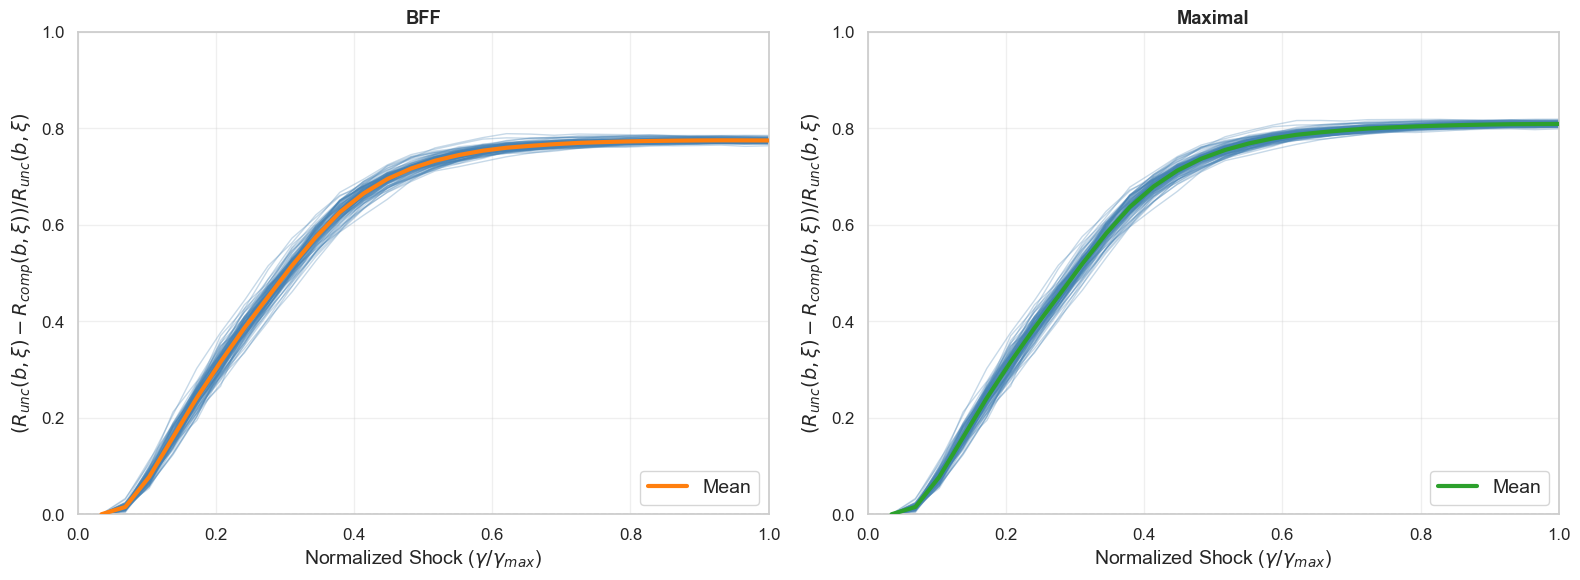

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

gamma_normalized = gamma_values / gamma_values.max()
mask = gamma_normalized > 0

# Plot 1: BFF
if 'BFF' in results_v2['methods']:
    reduction_shocks = results_v2['methods']['BFF']['reduction_all_shocks']
    reduction_mean = results_v2['methods']['BFF']['reduction_mean']
    reduction_p25 = results_v2['methods']['BFF']['reduction_p25']
    reduction_p75 = results_v2['methods']['BFF']['reduction_p75']

    # Plot individual shock scenario trajectories
    for shock_idx in range(NUM_SHOCK_SCENARIOS):
        ax1.plot(gamma_normalized[mask], reduction_shocks[mask, shock_idx],
                alpha=0.3, color='steelblue', linewidth=1)

    ax1.plot(gamma_normalized[mask], reduction_mean[mask],
            linewidth=3, color = '#ff7f0e', label='Mean', zorder=10)
    # ax1.fill_between(gamma_normalized[mask], reduction_p25[mask], reduction_p75[mask],
    #                  alpha=0.3, color='orange', label='25-75 percentile', zorder=5)
    ax1.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)

    ax1.set_xlabel(r'Normalized Shock ($\gamma / \gamma_{max}$)', fontsize=14)
    ax1.set_ylabel(r'$(R_{unc}(b,\xi) - R_{comp}(b,\xi)) / R_{unc}(b,\xi) $', fontsize=14)
    ax1.set_title(f'BFF', fontweight='bold')
    ax1.legend(fontsize=14,loc='lower right')
    ax1.grid(alpha=0.3)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)

# Plot 2: Maximal
if 'Maximal' in results_v2['methods']:
    reduction_shocks = results_v2['methods']['Maximal']['reduction_all_shocks']
    reduction_mean = results_v2['methods']['Maximal']['reduction_mean']
    reduction_p25 = results_v2['methods']['Maximal']['reduction_p25']
    reduction_p75 = results_v2['methods']['Maximal']['reduction_p75']

    # Plot individual shock scenario trajectories
    for shock_idx in range(NUM_SHOCK_SCENARIOS):
        ax2.plot(gamma_normalized[mask], reduction_shocks[mask, shock_idx],
                alpha=0.3, color='steelblue', linewidth=1)

    ax2.plot(gamma_normalized[mask], reduction_mean[mask],
            linewidth=3, color='#2ca02c', label='Mean', zorder=10)
    # ax2.fill_between(gamma_normalized[mask], reduction_p25[mask], reduction_p75[mask],
    #                  alpha=0.3, color='orange', label='25-75 percentile', zorder=5)
    ax2.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)

    ax2.set_xlabel(r'Normalized Shock ($\gamma / \gamma_{max}$)', fontsize=14)
    ax2.set_ylabel(r'$(R_{unc}(b,\xi) - R_{comp}(b,\xi)) / R_{unc}(b,\xi) $', fontsize=14)
    ax2.set_title(f'Maximal', fontweight='bold')
    ax2.legend(fontsize=14,loc='lower right')
    ax2.grid(alpha=0.3)
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('figures/Experiment1_v2_SB_individual_shock_trajectory_average_over_nets.png', dpi=300, bbox_inches='tight')

plt.show()

## 7b. Combined Plot: Shock Scenario Variability

Show mean and variability bands across shock scenarios.

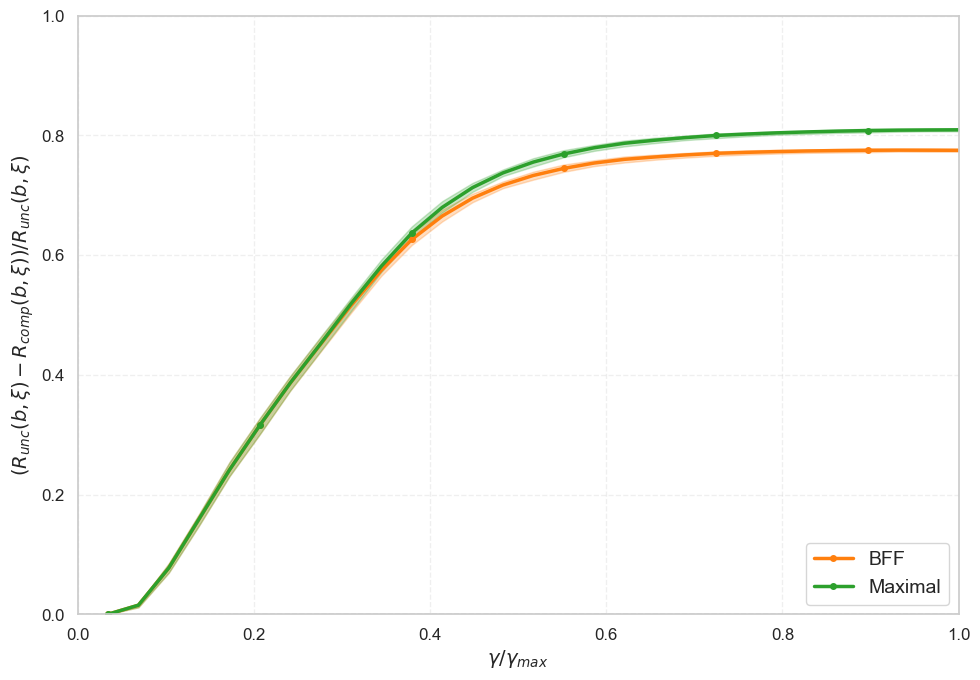

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# Normalize gamma
gamma_normalized = gamma_values / gamma_values.max()
mask = gamma_normalized > 0  # Exclude gamma=0

for method_name in ['BFF', 'Maximal']:
    if method_name not in results_v2['methods']:
        continue

    reduction_mean = results_v2['methods'][method_name]['reduction_mean'][mask]
    reduction_p25 = results_v2['methods'][method_name]['reduction_p25'][mask]
    reduction_p75 = results_v2['methods'][method_name]['reduction_p75'][mask]
    flow_retained = results_v2['methods'][method_name]['flow_retained']

    # Plot mean line
    label = f'{method_name}'
    color = '#ff7f0e' if method_name == 'BFF' else '#2ca02c'
    line = ax.plot(gamma_normalized[mask], reduction_mean, linewidth=2.5,
                   label=label, marker='o', markersize=4, markevery=5, color=color)[0]

    # Fill 25-75 percentile band
    ax.fill_between(gamma_normalized[mask], reduction_p25, reduction_p75,
                    alpha=0.25, color=color)

# Reference line
ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel(r'$\gamma / \gamma_{max}$', fontsize=14, fontweight='bold')
ax.set_ylabel(r'$(R_{unc}(b,\xi) - R_{comp}(b,\xi)) / R_{unc}(b,\xi)$', fontsize=14, fontweight='bold')
# ax.set_title(f'Risk Reduction vs Shock Magnitude\n' +
#              f'Mean across {NUM_SHOCK_SCENARIOS} shock scenarios (each averaged over {NUM_NETWORKS} networks)\n' +
#              f'Shaded: Shock scenario variability (25-75 percentile)',
#              fontsize=13, fontweight='bold')
ax.legend(fontsize=14, loc='lower right')
ax.grid(alpha=0.3, linestyle='--')
ax.set_xlim(0, 1)
ax.set_ylim(bottom=0, top=1)
plt.savefig('figures/Experiment1_v2_figure1_risk_comparison_average_over_nets.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

## Check 4 different shock scenario.
Apply only one shock to 500 networks sampled.

Generating box plots for individual shock behavior...
  Processing network 5/500 for box plots...
  Processing network 10/500 for box plots...
  Processing network 15/500 for box plots...
  Processing network 20/500 for box plots...
  Processing network 25/500 for box plots...
  Processing network 30/500 for box plots...
  Processing network 35/500 for box plots...
  Processing network 40/500 for box plots...
  Processing network 45/500 for box plots...
  Processing network 50/500 for box plots...
  Processing network 55/500 for box plots...
  Processing network 60/500 for box plots...
  Processing network 65/500 for box plots...
  Processing network 70/500 for box plots...
  Processing network 75/500 for box plots...
  Processing network 80/500 for box plots...
  Processing network 85/500 for box plots...
  Processing network 90/500 for box plots...
  Processing network 95/500 for box plots...
  Processing network 100/500 for box plots...
  Processing network 105/500 for box plots...


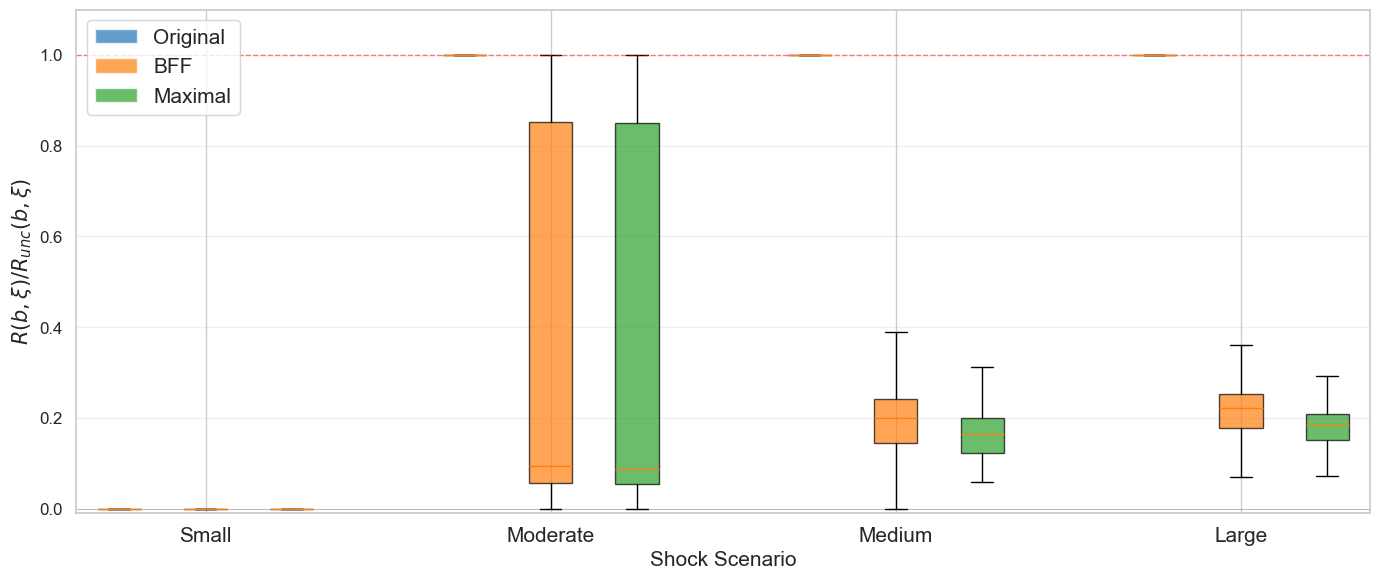

✓ Box plots generated
  Showing distribution across 500 networks for each scenario
  Values normalized by R_unc: R_comp / R_unc
  If R_unc = 0 (no shortfall), normalized value = 0
  Lower values = better compression (more risk reduction)


In [24]:
print("Generating box plots for individual shock behavior...")
print("=" * 70)

# Shock scenarios to test
shock_scenarios = {
    'Small': 0.001 * median_buffer,   # Minimal shock
    'Moderate': 1 * median_buffer,  # Moderate shock
    'Medium': 2 * median_buffer,    # Medium shock
    'Large': 3 * median_buffer      # Severe shock
}

# Storage for box plot data (normalized by R_unc)
boxplot_data = {
  method: {scenario: [] for scenario in shock_scenarios.keys()}
  for method in active_methods if method != 'Original'
}

# Storage for original network data (for plotting)
orig_boxplot_data = {scenario: [] for scenario in shock_scenarios.keys()}

# Run simulations for box plots
for net_idx in range(NUM_NETWORKS):
  if (net_idx + 1) % 5 == 0:
      print(f"  Processing network {net_idx + 1}/{NUM_NETWORKS} for box plots...")

  W_orig = networks_list['Original'][net_idx]
  buffer_orig = buffers_list[net_idx]

  # For each shock scenario
  for scenario_name, gamma in shock_scenarios.items():
      # Generate ONE shock per scenario (not averaged)
      shock_seed = shock_base_seed + net_idx * 1000 + hash(scenario_name) % 100000
      epsilon = generate_gaussian_copula_shocks(N_total, rho, n_samples=1, seed=shock_seed).ravel()

      # Compute original network shortfall (for normalization)
      R_unc_raw = compute_system_shortfall(W_orig, buffer_orig, gamma, epsilon)

      # For each compression method
      for method_name in active_methods:
          if method_name == 'Original':
              continue

          W_comp = networks_list[method_name][net_idx]
          R_comp_raw = compute_system_shortfall(W_comp, buffer_orig, gamma, epsilon)
          
          # Normalize by R_unc
          # If R_unc = 0, then both networks have zero shortfall, so normalized value = 0
          if R_unc_raw > 1e-12:  # Use small threshold to avoid numerical issues
              R_comp_norm = R_comp_raw / R_unc_raw
          else:
              R_comp_norm = 0.0  # No shortfall case

          # Store normalized shortfall for box plots
          boxplot_data[method_name][scenario_name].append(R_comp_norm)
      
      # Store original network data (always 1.0 when R_unc > 0, else 0.0)
      if R_unc_raw > 1e-12:
          orig_boxplot_data[scenario_name].append(1.0)
      else:
          orig_boxplot_data[scenario_name].append(0.0)

print()
print("✓ Box plot data collection complete")
print(f"  Sample sizes per method per scenario: {len(boxplot_data['BFF']['Medium'])}")

# Create box plots
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

positions = []
box_data = []
colors = []

scenario_names = ['Small', 'Moderate', 'Medium', 'Large']
base_position = 0

for scenario_idx, scenario in enumerate(scenario_names):
  # Position for this scenario group
  pos_start = base_position + scenario_idx * 4

  # Get data
  orig_data = orig_boxplot_data[scenario]
  bff_data = boxplot_data['BFF'][scenario]
  max_data = boxplot_data['Maximal'][scenario]

  # Add to plotting data
  box_data.extend([orig_data, bff_data, max_data])
  positions.extend([pos_start + 1, pos_start + 2, pos_start + 3])
  colors.extend(['#1f77b4', '#ff7f0e', '#2ca02c'])

# Create box plot
bp = ax.boxplot(box_data, positions=positions, patch_artist=True,
              widths=0.5, showfliers=False)

# Color the boxes
for patch, color in zip(bp['boxes'], colors):
  patch.set_facecolor(color)
  patch.set_alpha(0.7)

# Labels and formatting
scenario_labels = [
  r'Small',
  r'Moderate',
  r'Medium',
  r'Large'
]
scenario_positions = [2, 6, 10, 14]

ax.set_xticks(scenario_positions)
ax.set_xticklabels(scenario_labels, fontsize=15)
ax.set_xlabel('Shock Scenario', fontsize=15)
ax.set_ylabel(r'$R(b,\xi) / R_{unc}(b,\xi)$', fontsize=15)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
  Patch(facecolor='#1f77b4', alpha=0.7, label='Original'),
  Patch(facecolor='#ff7f0e', alpha=0.7, label='BFF'),
  Patch(facecolor='#2ca02c', alpha=0.7, label='Maximal')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=15)

# Add reference lines
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)
ax.axhline(y=1, color='red', linestyle='--', alpha=0.5, linewidth=1, label='Original baseline')

ax.grid(axis='y', alpha=0.3)
ax.set_ylim(bottom=-0.01, top=1.1)
plt.savefig('figures/Experiment1_figure2_reduction_vs_gamma.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

print("✓ Box plots generated")
print(f"  Showing distribution across {NUM_NETWORKS} networks for each scenario")
print(f"  Values normalized by R_unc: R_comp / R_unc")
print(f"  If R_unc = 0 (no shortfall), normalized value = 0")
print(f"  Lower values = better compression (more risk reduction)")

Generating box plots for individual shock behavior...
  Processing network 5/500 for box plots...
  Processing network 10/500 for box plots...
  Processing network 15/500 for box plots...
  Processing network 20/500 for box plots...
  Processing network 25/500 for box plots...
  Processing network 30/500 for box plots...
  Processing network 35/500 for box plots...
  Processing network 40/500 for box plots...
  Processing network 45/500 for box plots...
  Processing network 50/500 for box plots...
  Processing network 55/500 for box plots...
  Processing network 60/500 for box plots...
  Processing network 65/500 for box plots...
  Processing network 70/500 for box plots...
  Processing network 75/500 for box plots...
  Processing network 80/500 for box plots...
  Processing network 85/500 for box plots...
  Processing network 90/500 for box plots...
  Processing network 95/500 for box plots...
  Processing network 100/500 for box plots...
  Processing network 105/500 for box plots...


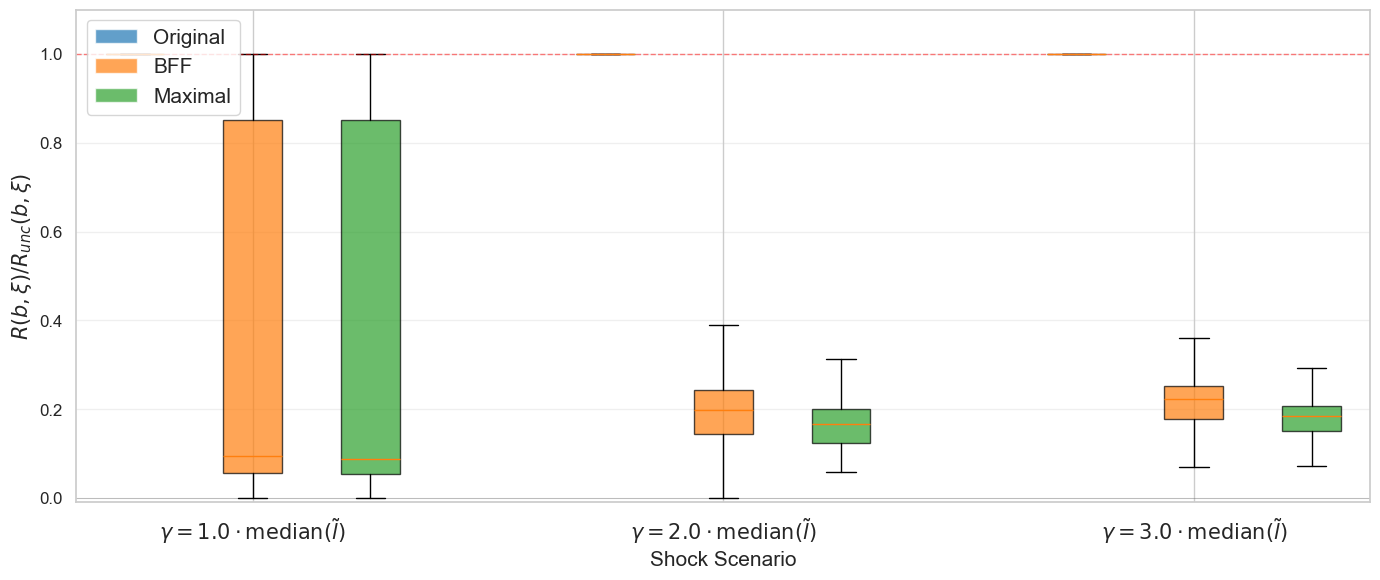

✓ Box plots generated
  Showing distribution across 500 networks for each scenario
  Values normalized by R_unc: R_comp / R_unc
  If R_unc = 0 (no shortfall), normalized value = 0
  Lower values = better compression (more risk reduction)


In [31]:
print("Generating box plots for individual shock behavior...")
print("=" * 70)

# Shock scenarios to test
shock_scenarios = {
    # 'Small': 0.001 * median_buffer,   # Minimal shock
    'Moderate': 1 * median_buffer,  # Moderate shock
    'Medium': 2 * median_buffer,    # Medium shock
    'Large': 3 * median_buffer      # Severe shock
}

# Storage for box plot data (normalized by R_unc)
boxplot_data = {
  method: {scenario: [] for scenario in shock_scenarios.keys()}
  for method in active_methods if method != 'Original'
}

# Storage for original network data (for plotting)
orig_boxplot_data = {scenario: [] for scenario in shock_scenarios.keys()}

# Run simulations for box plots
for net_idx in range(NUM_NETWORKS):
  if (net_idx + 1) % 5 == 0:
      print(f"  Processing network {net_idx + 1}/{NUM_NETWORKS} for box plots...")

  W_orig = networks_list['Original'][net_idx]
  buffer_orig = buffers_list[net_idx]

  # For each shock scenario
  for scenario_name, gamma in shock_scenarios.items():
      # Generate ONE shock per scenario (not averaged)
      shock_seed = shock_base_seed + net_idx * 1000 + hash(scenario_name) % 100000
      epsilon = generate_gaussian_copula_shocks(N_total, rho, n_samples=1, seed=shock_seed).ravel()

      # Compute original network shortfall (for normalization)
      R_unc_raw = compute_system_shortfall(W_orig, buffer_orig, gamma, epsilon)

      # For each compression method
      for method_name in active_methods:
          if method_name == 'Original':
              continue

          W_comp = networks_list[method_name][net_idx]
          R_comp_raw = compute_system_shortfall(W_comp, buffer_orig, gamma, epsilon)
          
          # Normalize by R_unc
          # If R_unc = 0, then both networks have zero shortfall, so normalized value = 0
          if R_unc_raw > 1e-12:  # Use small threshold to avoid numerical issues
              R_comp_norm = R_comp_raw / R_unc_raw
          else:
              R_comp_norm = 0.0  # No shortfall case

          # Store normalized shortfall for box plots
          boxplot_data[method_name][scenario_name].append(R_comp_norm)
      
      # Store original network data (always 1.0 when R_unc > 0, else 0.0)
      if R_unc_raw > 1e-12:
          orig_boxplot_data[scenario_name].append(1.0)
      else:
          orig_boxplot_data[scenario_name].append(0.0)

print()
print("✓ Box plot data collection complete")
print(f"  Sample sizes per method per scenario: {len(boxplot_data['BFF']['Medium'])}")

# Create box plots
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

positions = []
box_data = []
colors = []

scenario_names = ['Moderate', 'Medium', 'Large']
base_position = 0

for scenario_idx, scenario in enumerate(scenario_names):
  # Position for this scenario group
  pos_start = base_position + scenario_idx * 4

  # Get data
  orig_data = orig_boxplot_data[scenario]
  bff_data = boxplot_data['BFF'][scenario]
  max_data = boxplot_data['Maximal'][scenario]

  # Add to plotting data
  box_data.extend([orig_data, bff_data, max_data])
  positions.extend([pos_start + 1, pos_start + 2, pos_start + 3])
  colors.extend(['#1f77b4', '#ff7f0e', '#2ca02c'])

# Create box plot
bp = ax.boxplot(box_data, positions=positions, patch_artist=True,
              widths=0.5, showfliers=False)

# Color the boxes
for patch, color in zip(bp['boxes'], colors):
  patch.set_facecolor(color)
  patch.set_alpha(0.7)

# Labels and formatting

scenario_labels = [
    r'$\gamma = 1.0 \cdot \mathrm{median}(\tilde{l})$',
    r'$\gamma = 2.0 \cdot \mathrm{median}(\tilde{l})$',
    r'$\gamma = 3.0 \cdot \mathrm{median}(\tilde{l})$'
]
scenario_positions = [2, 6, 10]

ax.set_xticks(scenario_positions)
ax.set_xticklabels(scenario_labels, fontsize=15)
ax.set_xlabel('Shock Scenario', fontsize=15)
ax.set_ylabel(r'$R(b,\xi) / R_{unc}(b,\xi)$', fontsize=15)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
  Patch(facecolor='#1f77b4', alpha=0.7, label='Original'),
  Patch(facecolor='#ff7f0e', alpha=0.7, label='BFF'),
  Patch(facecolor='#2ca02c', alpha=0.7, label='Maximal')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=15)

# Add reference lines
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)
ax.axhline(y=1, color='red', linestyle='--', alpha=0.5, linewidth=1, label='Original baseline')

ax.grid(axis='y', alpha=0.3)
ax.set_ylim(bottom=-0.01, top=1.1)
plt.savefig('figures/Experiment1_figure2_reduction_vs_gamma.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

print("✓ Box plots generated")
print(f"  Showing distribution across {NUM_NETWORKS} networks for each scenario")
print(f"  Values normalized by R_unc: R_comp / R_unc")
print(f"  If R_unc = 0 (no shortfall), normalized value = 0")
print(f"  Lower values = better compression (more risk reduction)")